In [1]:
import sys
parent_dir = ".."
sys.path.append(parent_dir)

In [2]:
from ast import literal_eval
import os
import pickle
from functools import reduce

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from default_config import default_config
from gnd_dataset import GNDDataset
from gnd_graph import GNDGraph


In [3]:
config = default_config
res_dir = "../results"
pred_files = [
    "few-shot-3k-title-retrieval-3b",
    "hard-prompting-3b-context-label-3k-1h-ft",
    "few-shot-ft-3k-1hop-label-retrieval-3b",
    "hard-prompting-baseline"
    
    ]
gnd_path  = os.path.join("..", config["graph_path"])
gnd_graph = pickle.load(open(gnd_path, "rb"))
gnd_graph = GNDGraph(gnd_graph)

In [55]:
gnd_ds = GNDDataset(
    data_dir= os.path.join("..", config["dataset_path"]),
    gnd_graph=gnd_graph,
    config=config,
    load_from_disk=True,
)
test_ds = gnd_ds["test"]

In [56]:
indices = [3596, 8273, 245, 7691, 6005]
doc_idns = list(test_ds[indices]["doc_idn"])
doc_idns.sort()

In [57]:
cols = ["reranked-predictions", "label-ids", "scores"]

In [58]:
def get_eval_dfs(exp_dir, doc_idns, k=3):
    exp_path = os.path.join(res_dir, exp_dir)
    exp_files = [os.path.join(exp_path, exp) for exp in os.listdir(exp_path) if exp.endswith(".csv")]
    top_k_dict = {}
    for exp in exp_files:
        test_df = pd.read_csv(exp)
        for c in cols:
            test_df[c] = test_df[c].apply(literal_eval)
        sampled = test_df[test_df["doc_idn"].isin(doc_idns)]
        sampled = sampled.sort_values(by="doc_idn")
        for _, record in sampled.iterrows():
            doc_idn = record["doc_idn"]
            if doc_idn not in top_k_dict:
                top_k_dict[doc_idn] = {}
            for pred, score in zip(record["reranked-predictions"], record["scores"]):
                top_k_dict[doc_idn][pred] = score
    for doc in top_k_dict:
        top_pred = sorted(top_k_dict[doc], key=lambda x: top_k_dict[doc][x], reverse=True)[:k]
        top_k_dict[doc] = {idn: top_k_dict[doc][idn] for idn in top_pred}
    return [pd.DataFrame.from_dict(top_k_dict[doc], orient="index", columns=[exp_dir]) for doc in top_k_dict]


In [59]:
all_df = []
for exp in pred_files:
    dfs = get_eval_dfs(exp, doc_idns=doc_idns)
    all_df.append(dfs)

In [34]:
merged_all = []
for i in zip(*all_df):
    df_merged = reduce(lambda  left,right: pd.merge(left,right,
                                            how='outer', left_index=True, right_index=True), i)
    merged_all.append(df_merged)

In [61]:
test_ds = test_ds.to_pandas()

In [62]:
final_df = []
for doc_idx, merged_df in zip(doc_idns, merged_all):
    print(doc_idx)
    sample = test_ds[test_ds["doc_idn"] == doc_idx]
    merged_df["id"] = merged_df.index
    title = sample["title"]
    golds = sample["label-ids"].tolist()[0]
    fn = []
    for g_idn in golds:
        if g_idn not in merged_df["id"]:
            g_dict = {"id": g_idn}
            for col in merged_df.columns:
                if col not in g_dict:
                    g_dict[col] = 0.0
            fn.append(g_dict)
    gold_df = pd.DataFrame(fn)
    if gold_df.shape[0] > 0:
        merged_df = pd.concat((merged_df, gold_df))
    merged_df["label"] = merged_df["id"].apply(lambda x: gnd_graph.pref_label_name(x))
    merged_df["gold"] = merged_df["id"].apply(lambda x: x in golds)
    merged_df = merged_df.reset_index(drop=True)
    final_df.append(merged_df)

1127857169
1191749517
1231631708
1255741104
1272409643


In [66]:
x = 4
final_df[x].sort_values(by="gold", ascending=False)

,few-shot-3k-title-retrieval-3b,hard-prompting-3b-context-label-3k-1h-ft,few-shot-ft-3k-1hop-label-retrieval-3b,hard-prompting-baseline,id,label,gold
7,0.000000,0.000000,0.000000,0.000000,127402370X,Trans Atlantik (Zeitschrift),True
0,0.033970,0.033970,NaN,0.033970,00128083X,Salvatorianer,False
1,NaN,NaN,0.009650,NaN,040118827,Deutschland,False
2,NaN,0.011656,NaN,NaN,040359492,Literarische Zeitschrift,False
3,0.125669,NaN,NaN,0.125669,040674886,Zeitschrift,False
4,0.153000,0.153000,NaN,0.153000,118530534,"Enzensberger, Hans Magnus (1929-2022)",False
5,NaN,NaN,0.947212,NaN,118605186,"Salvatore, Gaston",False
6,NaN,NaN,0.006451,NaN,120016060,"Enzensberger, Ulrich",False


In [23]:
df = pd.read_csv(os.path.join("..\qualitative_analysis\difficult_examples.csv"))

x = []
y = []
d = {}
for column in df.columns:
    if column.endswith("rating"):
        df[column] = df[column].apply(literal_eval)
        ratings = [rate_value for rate_list in df[column] for rate_value in rate_list]
        d[column] = ratings
        x.extend(ratings)
        y.extend([column for i in range(len(ratings))])


In [21]:
df.columns

Index(['Unnamed: 0', 'title', 'doc_idn', 'label-ids',
       'prompt-tuning-baseline-full', 'prompt-tuning-baseline-full-rating',
       'pt-txt-context-3-label', 'pt-txt-context-3-label-rating',
       'prompt-tuning-from_gnd', 'prompt-tuning-from_gnd-rating'],
      dtype='object')

In [40]:
examples = df.sample(3, random_state=30)
examples["label-ids"] = examples["label-ids"].apply(literal_eval)
examples["prompt-tuning-baseline-full"] = examples["prompt-tuning-baseline-full"].apply(literal_eval)
examples["prompt-tuning-from_gnd"] = examples["prompt-tuning-from_gnd"].apply(literal_eval)
examples["pt-txt-context-3-label"] = examples["pt-txt-context-3-label"].apply(literal_eval)
for i, row in examples.iterrows():
    print(row["title"])
    print("Gold labels")
    for i in row["prompt-tuning-baseline-full"]:
        print(gnd.pref_label_name(i), end="; ")
    print()
    

Herausforderungen und Limitationen von hybriden Metall-Kunststoff-Verbunden in Gehäusestrukturen von PKW-Getrieben
Gold labels
Leichtbetonkonstruktion; Aluminium; Met; Aluminiumlegierung; Personenkraftwagen; Hybridantrieb; Blechumformen; le; Metallbau; Hybridbauweise; Leichtbau; Fahrzeuggetriebe; Fasertaper; Getriebe; 
"Semper ad fontes" Festschrift für Christian Lackner zum 60. Geburtstag
Gold labels
Ästhetische Wahrnehmung; Recht; Kunst; Theorie; Literatur; Theologie; Ästhetik; Martin, Christian (1950); Theologische Ethik; Semiotik; Deutsch; Rechtswissenschaft; Lack; Rezeption; 
Der Einfluss oberflächennaher Spannungsgradienten auf das Very High Cycle Fatigue Verhalten des Vergütungsstahls 42CrMo4
Gold labels
Gefüge (Werkstoffkunde); Spannungsfall; Stahl; Fadenstern; Schweißstahl; Mechanische Beanspruchung; Schadensmechanik; Rissbildung; Hochfester Stahl; Chrom-Molybdän-Stahl; Berechnung; 


In [4]:
for k, v in d.items():
    print(k)
    v = pd.Series(v)
    value_count = v.value_counts() / len(v)
    mask = value_count.index <= 0
    not_helpful = value_count[mask]
    helpful = value_count[~mask]
    print(not_helpful.sum())
    print(helpful.sum())


prompt-tuning-baseline-full-rating
0.8065233506300964
0.19347664936990364
pt-txt-context-3-label-rating
0.7983651226158038
0.2016348773841962
prompt-tuning-from_gnd-rating
0.7839687194525904
0.21603128054740958


C:\Users\HP I5\AppData\Local\Temp\ipykernel_8696\545010237.py:1: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.histplot(x=y, hue=x, palette=sns.color_palette())


<Axes: ylabel='Count'>

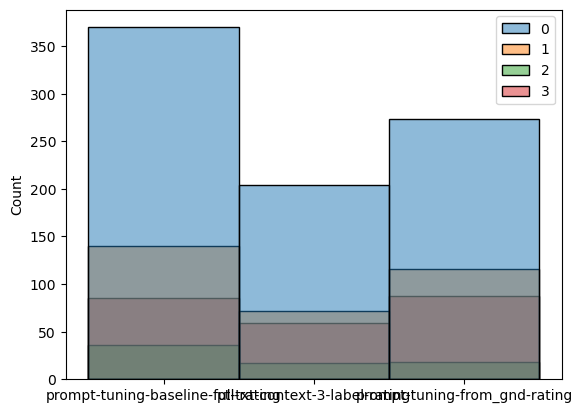

In [ ]:
sns.histplot(x=y, hue=x, palette=sns.color_palette())

In [5]:
ds = GNDDataset(
    data_dir=os.path.join(parent_dir, "dataset"),
    gnd_graph=gnd, 
    load_from_disk=True
)

# Identifying difficult or controversial inputs

In [6]:
paths = [
    "results/prompt-tuning-baseline-full",
    "results/pt-txt-context-3-label",
    "results/prompt-tuning-from_gnd",
    # "results\pt-from_gnd_w_alt"
]
all_results_df = ds["test"].to_pandas()
all_results_df = all_results_df.drop(0).reset_index()
for p in paths:
    p = os.path.join(parent_dir, p)
    files = [f for f in os.listdir(p) if f.endswith(".csv")]
    exp_name = os.path.basename(p)
    all_pred_exp = None
    for file in files:
        df = pd.read_csv(os.path.join(p, file))
        df = df["predictions"]
        df = df.apply(literal_eval)
        if all_pred_exp is None:
            all_pred_exp = df
        else:
            new = []
            for pred_current, pred_all in zip(df, all_pred_exp):
                combine = pred_current + pred_all
                combine = list(set(combine))
                new.append(combine)
            all_pred_exp = new
    all_results_df[exp_name] = all_pred_exp
    
    

In [10]:
c = [os.path.basename(p) for p in paths]
#c.append("label-ids")

all_results_df["unique_all"] = all_results_df[c].apply(lambda x: list(set(idn for list_i in x.values.tolist() for idn in list_i)), axis=1)
all_results_df["n_unique"] = all_results_df["unique_all"].str.len()

In [11]:
qual = all_results_df.sort_values(by="n_unique", ascending=False).head(100)
# qual = qual[qual["n_unique"] > 1]
possible_ratings = [-1, 0, 1, 2]
count = 0
qualitative_analysis = {
    "title": [],
    "doc_idn": [], 
    "label-ids": []
}

for experiment in c: 
    qualitative_analysis[experiment] = []
    qualitative_analysis[f"{experiment}-rating"] = []
count = 0
for index, row in qual.iterrows():
    count += 1
    title = row["title"]
    gold_labels = [gnd.pref_label_name(idn) for idn in row["label-ids"] if idn in gnd]
    print(count, index, "Title: ", title)
    qualitative_analysis["label-ids"].append(row["label-ids"])
    qualitative_analysis["title"].append(row["title"])
    qualitative_analysis["doc_idn"].append(row["doc_idn"])
    #print("Gold labels: ", ",".join(gold_labels))
    for exp in c:
        # print(f"{exp}: ", end="")
        preds = row[exp]
        qualitative_analysis[exp].append(preds)
        ratings = []
        for idn in preds:
            if idn in row["label-ids"]:
                ratings.append(3)
                continue
            # print(gnd.pref_label_name(idn), idn)
            rating = None
            ratings.append(rating)
            qualitative_analysis[f"{exp}-rating"].append(ratings)
    print("====="*30)

1 3891 Title:  Je dunkler die Nacht, desto heller die Sterne Über die Liebe, die Trauer und das Ich
2 2110 Title:  Photonische Eigenschaften eines eindimensionalen geordneten atomaren Mediums Photonic properties of one-dimensional atomic ordered medium
3 4602 Title:  Trügerische Verheißungen: Markterzählungen und ihre ungeplanten Folgen
4 3804 Title:  XXL-Leseprobe: Der Rikscha-Fahrer, der das Glück verschenkt
5 7505 Title:  Entgrenzung als Erkenntnis- und Gestaltungsaufgabe. Festschrift für Reimut Jochimsen zum 65. Geburtstag.
6 4343 Title:  Beschäftigtentransfer in der Luftfahrtbranche. Zustandekommen und Wirksamkeitsanalyse der Air Berlin-Transfergesellschaften Boden und Technik
7 448 Title:  Flachsinn Ich habe Hirn, ich will hier raus, plus E-Book inside (ePub, mobi oder pdf)
8 3727 Title:  Die nackte Wahrheit
9 3859 Title:  Nostalgie und Aufbruch Von der Lust, die Welt zu gestalten
10 1506 Title:  Altsein, Generation und Geschlecht in der Zeichnung junger Menschen Dokumentar

In [33]:
qualitative_analysis

{'title': [],
 'doc_idn': [],
 'label-ids': array(['040063496', '040316300', '040476863', '04060294X', '040607429',
        '04135740X', '1068493003'], dtype=object),
 'prompt-tuning-baseline-full': [['040718670',
   '041893999',
   '040677087',
   '043272002',
   '041165683',
   '040348644',
   '976362686',
   '979957095',
   '041237463',
   '04040949X',
   '040086909',
   '042908027',
   '040402355',
   '977099806',
   '040623866',
   '041574958']],
 'prompt-tuning-baseline-full-rating': [[-1, -1, -1, -1, -1, -1, 0, 0, 0, 0],
  [-1, -1, -1, -1, -1, -1, 0, 0, 0, 0],
  [-1, -1, -1, -1, -1, -1, 0, 0, 0, 0],
  [-1, -1, -1, -1, -1, -1, 0, 0, 0, 0],
  [-1, -1, -1, -1, -1, -1, 0, 0, 0, 0],
  [-1, -1, -1, -1, -1, -1, 0, 0, 0, 0],
  [-1, -1, -1, -1, -1, -1, 0, 0, 0, 0],
  [-1, -1, -1, -1, -1, -1, 0, 0, 0, 0],
  [-1, -1, -1, -1, -1, -1, 0, 0, 0, 0],
  [-1, -1, -1, -1, -1, -1, 0, 0, 0, 0]],
 'pt-txt-context-3-label': [],
 'pt-txt-context-3-label-rating': [],
 'prompt-tuning-from_gnd': [],
 'pro

In [ ]:
# Load the dataset

REPO_ID = "KatjaK/DNB-Titles"

# snapshot_download(repo_id=REPO_ID, repo_type="dataset", local_dir=os.path.join(parent_dir, "dataset"))

Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

dataset_info.json:   0%|          | 0.00/504 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/2.46k [00:00<?, ?B/s]

dataset_info.json:   0%|          | 0.00/504 [00:00<?, ?B/s]

state.json:   0%|          | 0.00/247 [00:00<?, ?B/s]

state.json:   0%|          | 0.00/247 [00:00<?, ?B/s]

data-00000-of-00001.arrow:   0%|          | 0.00/1.92M [00:00<?, ?B/s]

data-00000-of-00001.arrow:   0%|          | 0.00/16.2M [00:00<?, ?B/s]

dataset_info.json:   0%|          | 0.00/504 [00:00<?, ?B/s]

state.json:   0%|          | 0.00/247 [00:00<?, ?B/s]

'C:\\Users\\HP I5\\Dropbox\\Mein PC (DESKTOP-K8VH3NS)\\Documents\\Projects\\xmlc-knowledge\\dataset'